<a href="https://colab.research.google.com/github/Jahnavi-Jaolekar/Online-retail/blob/main/Online_Retail_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title :  Online Retail Customer Segmentation**

## **STEP 1 - Importing necessary libraries**

In [2]:
# Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime
import scipy
import scipy.stats as stat
import math
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## Libraries for Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## **STEP 2 - Import and taking overview of the data.**

In [3]:
# lets take a look at the data set
ORC_df=pd.read_excel('/content/drive/MyDrive/Data/Online Retail.xlsx')
ORC_df.head().style.set_properties(**{'border': '1.3px solid red',
                          'color': 'White'})

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550000,17850.000000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390000,17850.000000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750000,17850.000000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390000,17850.000000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390000,17850.000000,United Kingdom


# **Column Details**

#### Column Details

| Field | Description || Field | Description |
|-------|-------------||-------|-------------|
|Invoice_no.|Invoice number||Stock Code|Stock Name Code|
|Description|Description of product||Quantity|Quantity bought|
|Invoice Date|Invoice Date||Unit Price|Price per Unit|
|Customer ID|Unique Customer ID||Country|Location|


In [4]:
# Determining shape of the dataset
rows=ORC_df.shape[0]
columns=ORC_df.shape[1]
print(f'Number of rows in dataset are {rows}')
print(f'Number of columns in dataset are {columns}')

Number of rows in dataset are 541909
Number of columns in dataset are 8


In [5]:
# Information of the dataset
ORC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# Dataset Describe
ORC_df.describe().round(2).style.background_gradient().set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.550000,4.610000,15287.690000
std,218.080000,96.760000,1713.600000
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## **STEP 3 - Checking for presence of null values.**

In [7]:
# Defining function to determine null values in dataset and datatype of the data
def brief():
  values=pd.DataFrame(index=ORC_df.columns)
  values['Null Count']= ORC_df.isnull().sum()
  values['Dtype']=ORC_df.dtypes
  values['unique_count']= ORC_df.nunique()
  return values 

In [8]:
brief().style.set_properties(**{'border': '1.3px solid red',
                          'color': 'White'})

,Null Count,Dtype,unique_count
InvoiceNo,0,object,25900
StockCode,0,object,4070
Description,1454,object,4223
Quantity,0,int64,722
InvoiceDate,0,datetime64[ns],23260
UnitPrice,0,float64,1630
CustomerID,135080,float64,4372
Country,0,object,38


## **STEP 4 - Preprocessing and feature engineering.**

In [9]:
# Preprocessing of the dataset
ORC_df.InvoiceDate = pd.to_datetime(ORC_df.InvoiceDate)
ORC_df['Invoice_Year'] = ORC_df.InvoiceDate.dt.year
ORC_df['Invoice_Month'] = ORC_df.InvoiceDate.dt.month
ORC_df['Invoice_Day'] = ORC_df.InvoiceDate.dt.day
ORC_df['Invoice_WeekDay'] = ORC_df.InvoiceDate.dt.weekday
ORC_df['Total Price'] = ORC_df.Quantity * ORC_df.UnitPrice

In [10]:
# Feature preparation
ORC_df = ORC_df[(ORC_df.Quantity>0) & (ORC_df.UnitPrice>0)]
ORC_df.shape

(530104, 13)

In [11]:
# Dropping irrelevant columns
X = ORC_df.drop(['InvoiceNo','StockCode','InvoiceDate','CustomerID'],axis=1)

In [12]:
# Categorical Encoding
encoder = LabelEncoder()
X.Description = encoder.fit_transform(X.Description.astype(str))
X.Description = X.Description.astype(np.int64)

In [13]:
# Outlier Removal
for col in X.columns:
    if X[col].dtypes != object:
        lower_limit, upper_limit = X[col].quantile([0.25,0.75])
        IQR = upper_limit - lower_limit
        lower_whisker = lower_limit - 1.5 * IQR
        upper_whisker = upper_limit + 1.5 * IQR
        index = X[(X[col]<lower_whisker) & (X[col]>upper_whisker)].index
        X.drop(index,inplace=True)

## **STEP 5 - Exploratory data analysis**

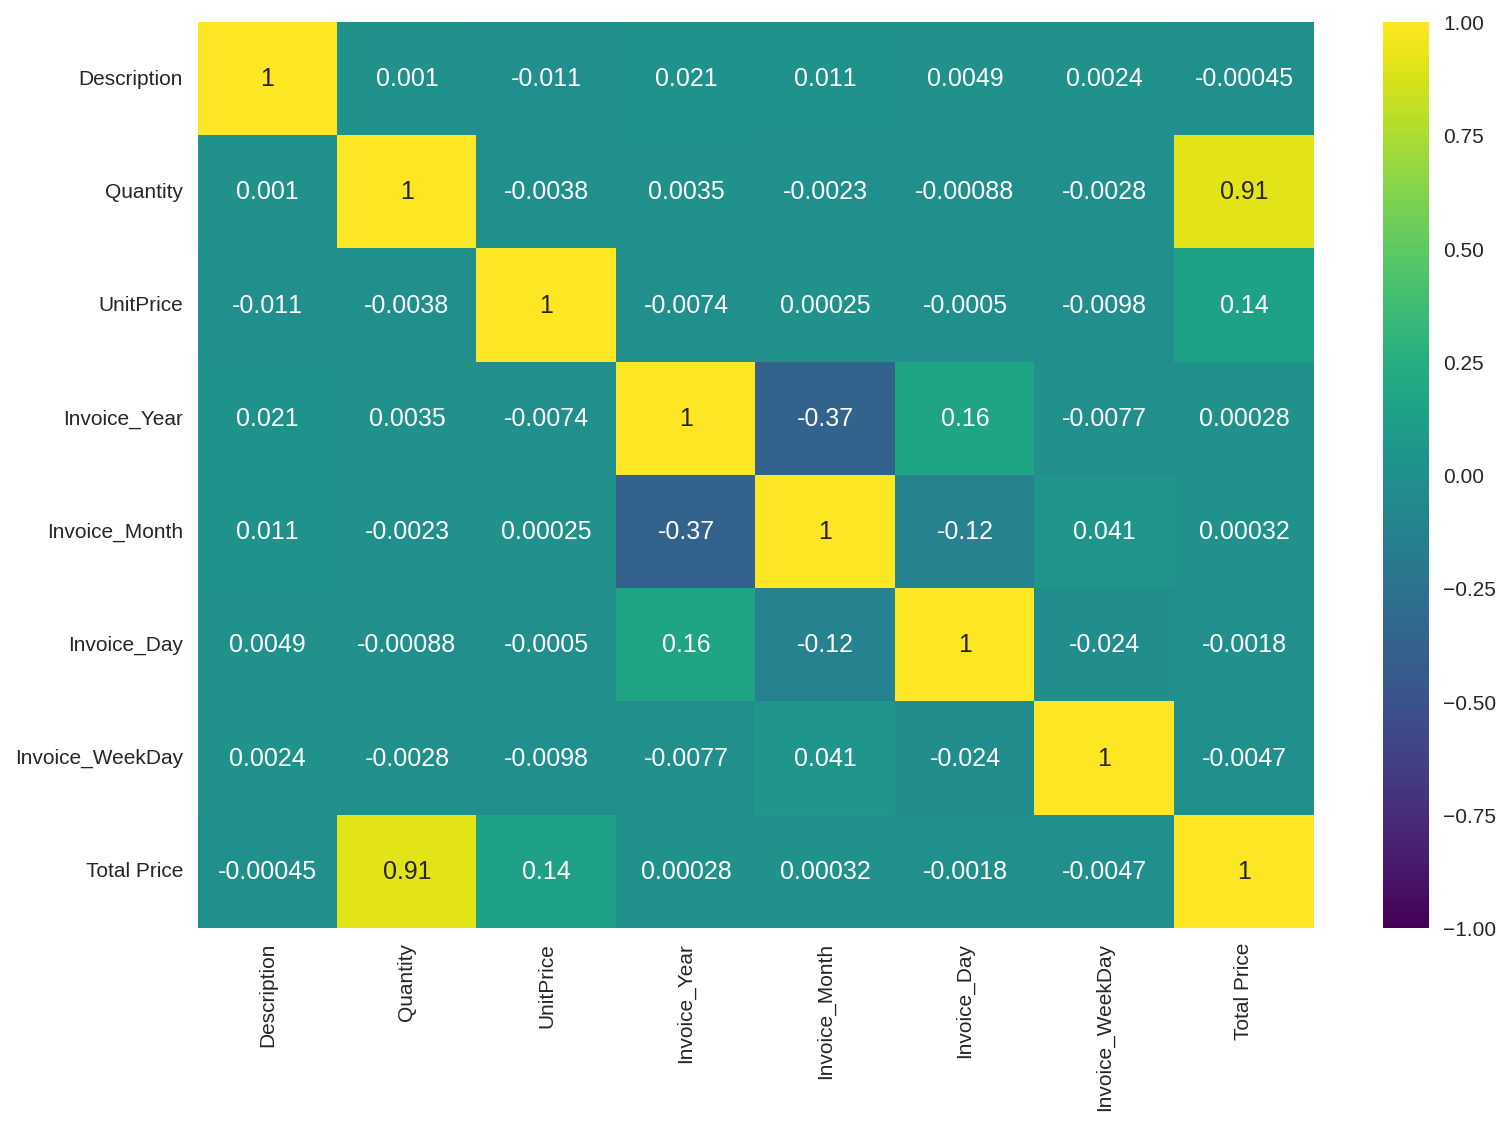

In [14]:
# chart-1
plt.figure(figsize=(12,8),dpi=150)
sns.heatmap(X.corr(),annot=True,cmap='viridis',vmin=-1,vmax=1)

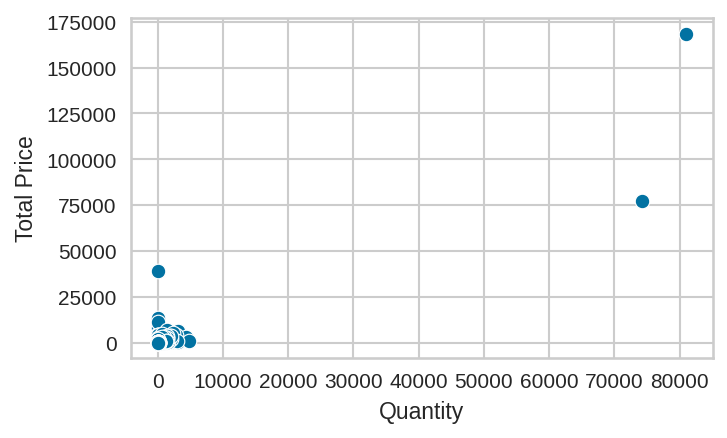

In [15]:
# Chart-2
plt.figure(figsize=(5,3),dpi=150)
sns.scatterplot(data=X,x='Quantity',y='Total Price')

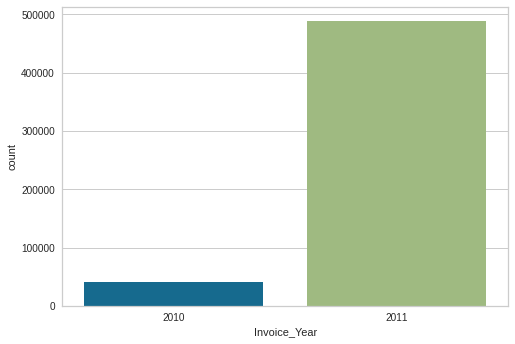

In [16]:
# Chart-3
sns.countplot(X.Invoice_Year)

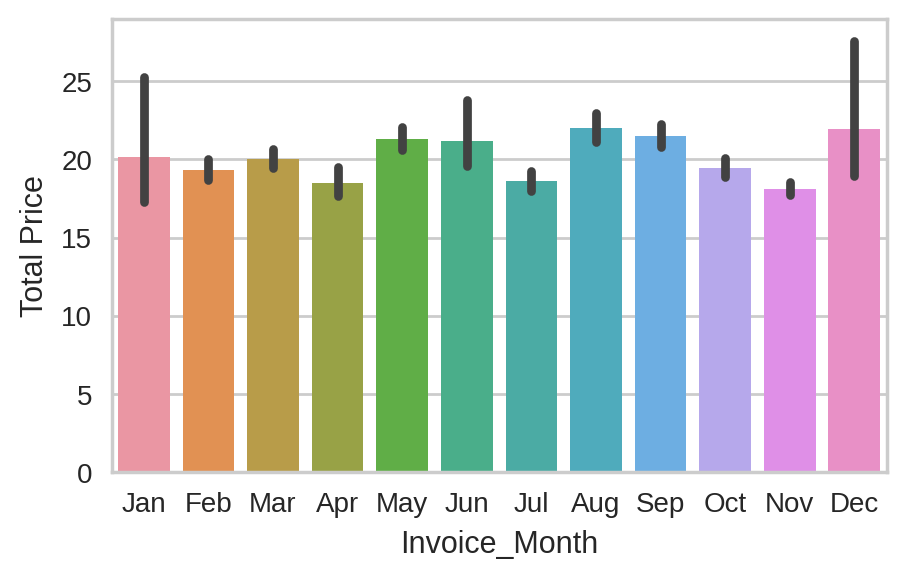

In [17]:
# Chart-4
plt.figure(figsize=(5,3),dpi=200)
ax = sns.barplot(data=X,x='Invoice_Month',y='Total Price')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

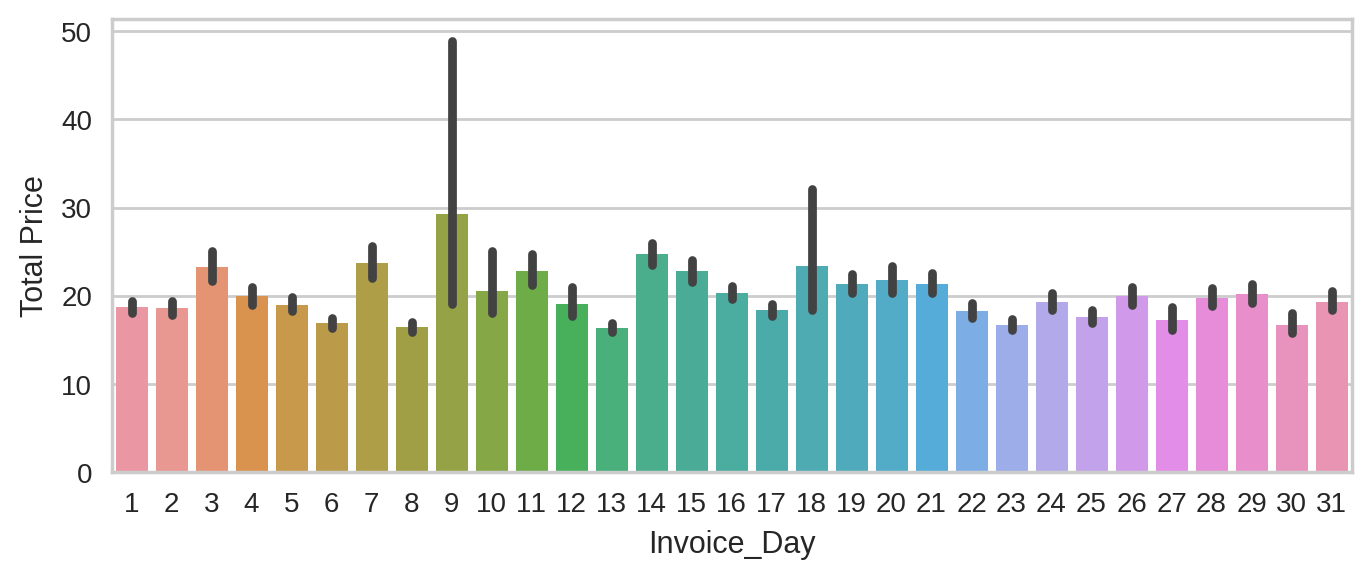

In [18]:
# Chart-5
plt.figure(figsize=(8,3),dpi=200)
sns.barplot(data=X,x='Invoice_Day',y='Total Price')

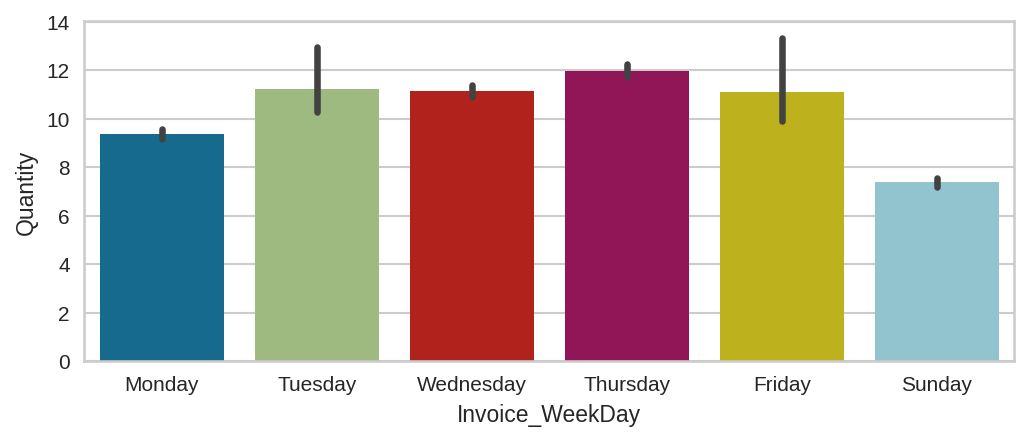

In [19]:
# Chart-6
plt.figure(figsize=(8,3),dpi=150)
ax = sns.barplot(data=X,x='Invoice_WeekDay',y='Quantity')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Sunday']);

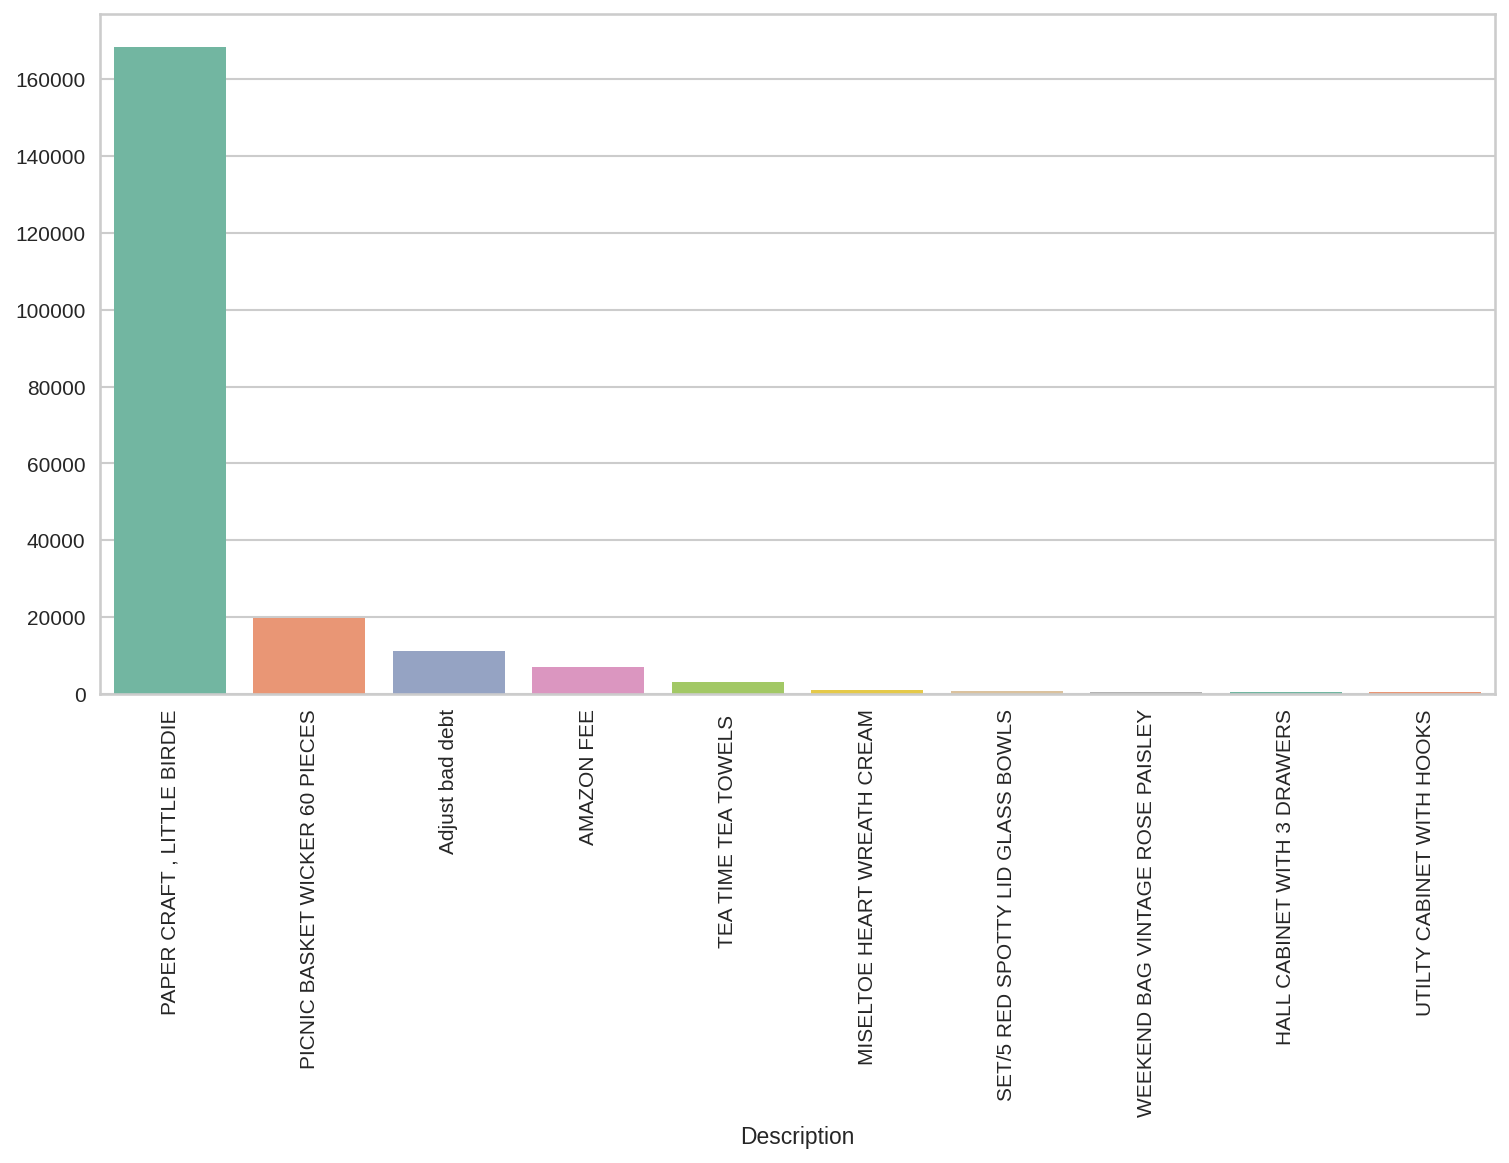

In [20]:
# Chart-7
plt.figure(figsize=(12,6),dpi=150)
sns.barplot(ORC_df.groupby('Description')['Total Price'].mean().sort_values(ascending=False)[:10].index,ORC_df.groupby('Description')['Total Price'].mean().sort_values(ascending=False)[:10].values,palette='Set2')
plt.xticks(rotation=90);

Skewness of Quantity: 471.7277163313442
Kurtosis of Quantity: 236462.34282634672


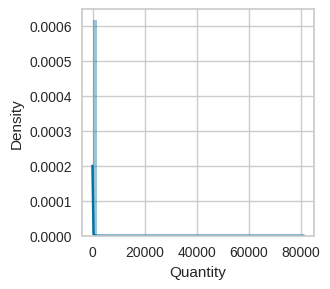

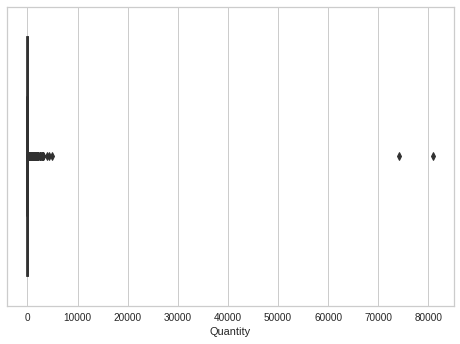

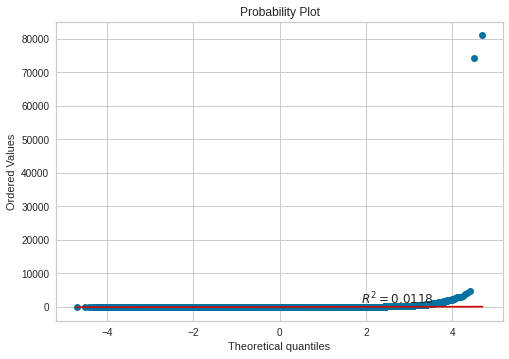

Skewness of UnitPrice: 206.08755495006463
Kurtosis of UnitPrice: 62483.14271510476


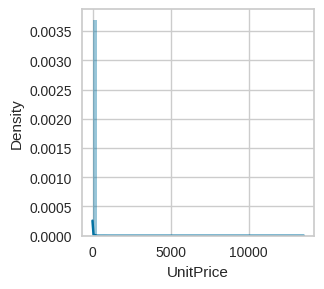

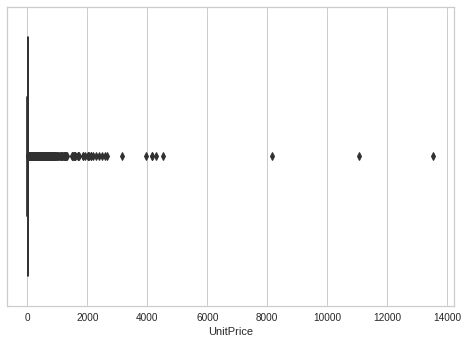

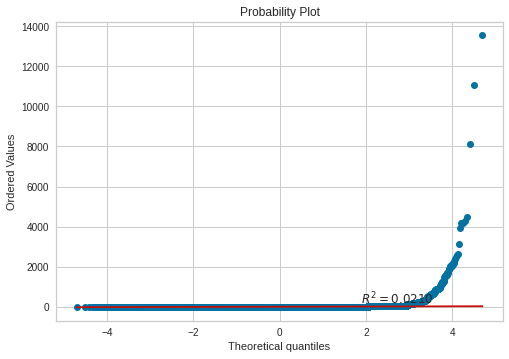

Skewness of Invoice_Year: -3.140811448329451
Kurtosis of Invoice_Year: 7.8647262263308715


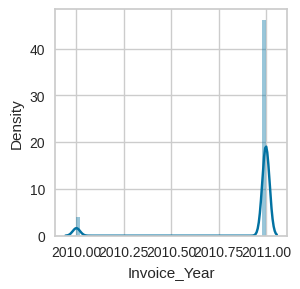

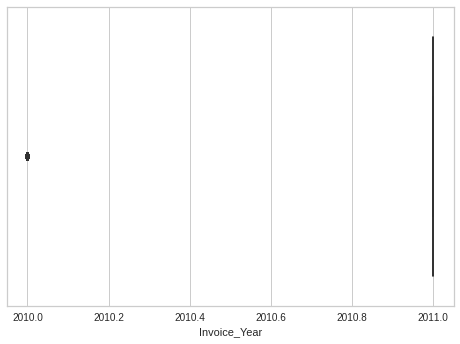

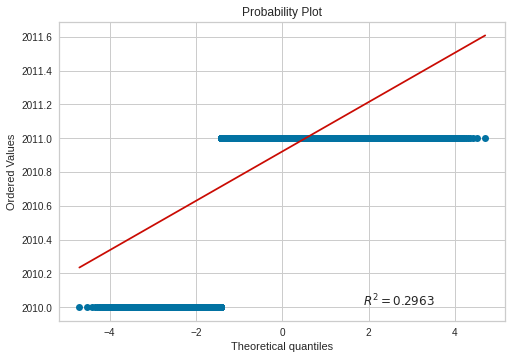

Skewness of Invoice_Month: -0.41841228696053556
Kurtosis of Invoice_Month: -1.1169946588288


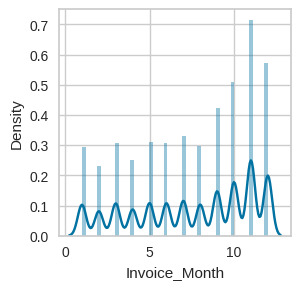

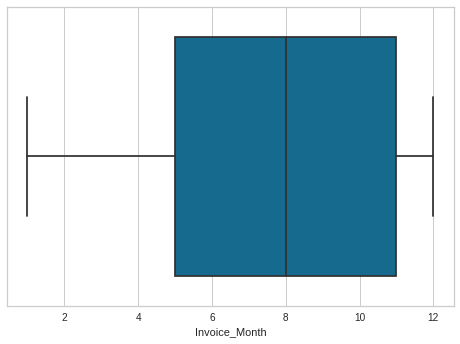

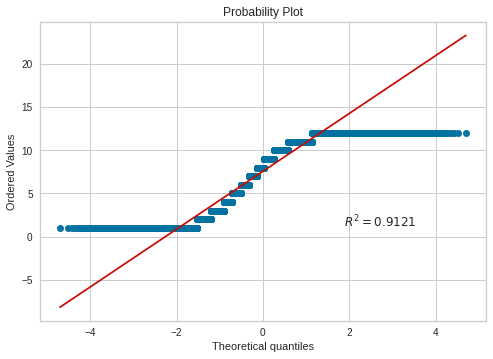

Skewness of Invoice_Day: 0.14208619030549433
Kurtosis of Invoice_Day: -1.1574107092128816


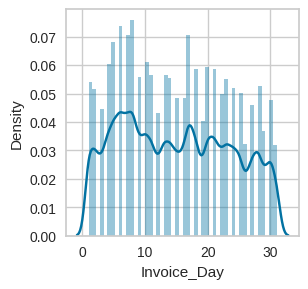

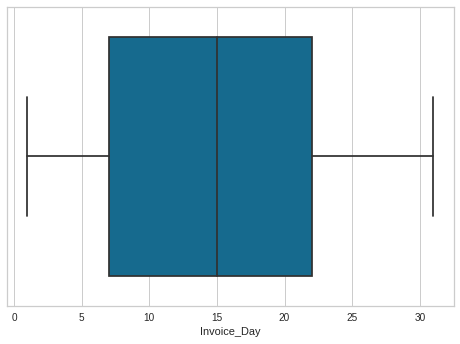

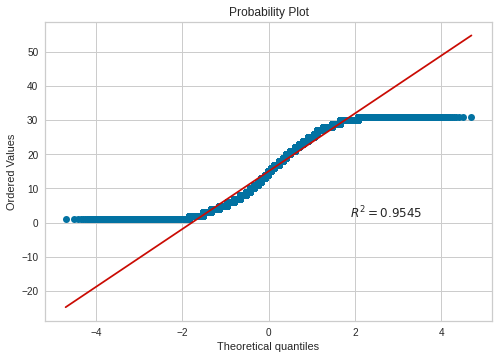

Skewness of Invoice_WeekDay: 0.4661824816962572
Kurtosis of Invoice_WeekDay: -0.6675789760994388


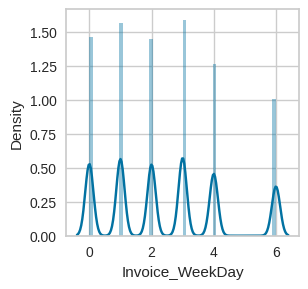

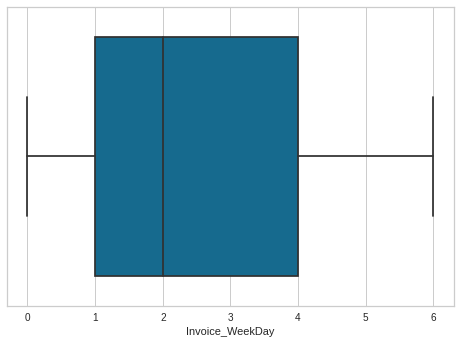

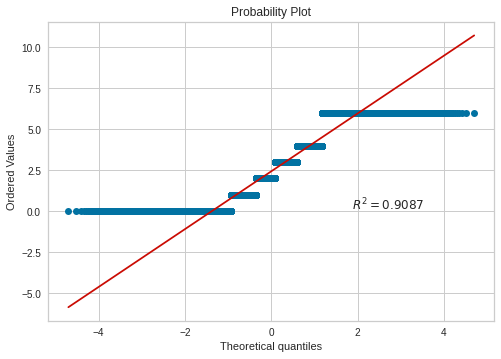

Skewness of Total Price: 506.7060119422723
Kurtosis of Total Price: 297651.6610458157


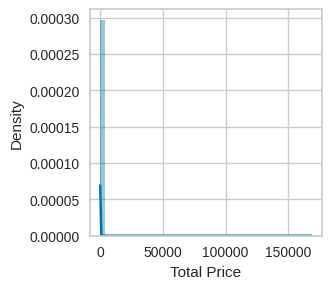

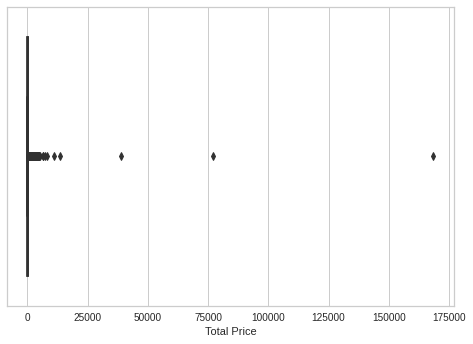

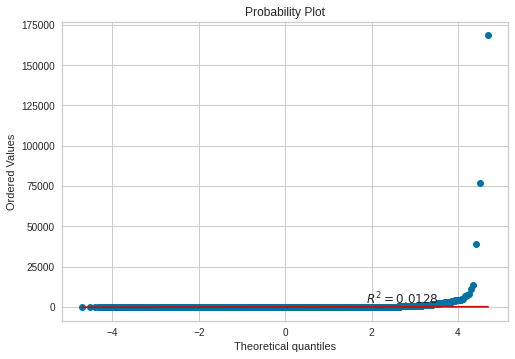

In [21]:
# Chart-8
for col in X.columns:
    if col not in ['Description','InvoiceYear']:
        if X[col].dtypes != object:
            print("Skewness of {}:".format(col),X[col].skew())
            print("Kurtosis of {}:".format(col),X[col].kurt())
            plt.figure(figsize=(3,3),dpi=100)
            sns.distplot(X[col])
            plt.show()
            sns.boxplot(data=X,x=col)
            plt.show()
            scipy.stats.probplot(X[col],plot=plt,rvalue=True)
            plt.show()

## **STEP 6 - Dealing with null values**

In [22]:
# Dropping null values
ORC_df.dropna(inplace=True)

## **STEP 7 - Recency Frequency Monetary**

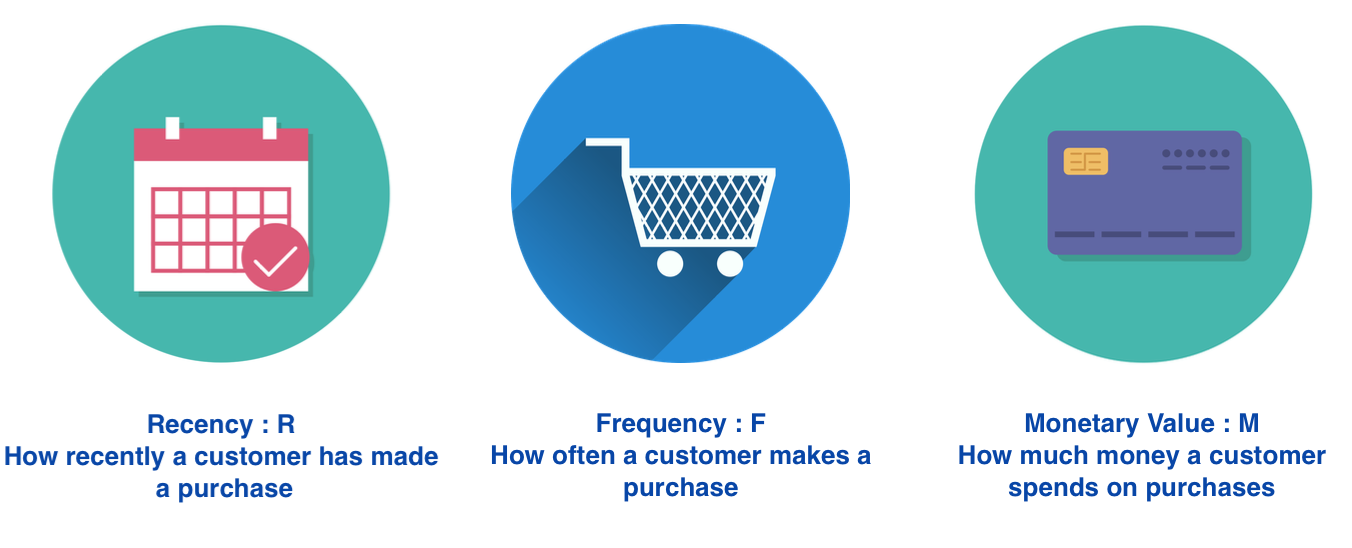

In [23]:
# Recency
reference_date = ORC_df.InvoiceDate.max()

#timedelta function returns to total number of seconds
reference_date = reference_date + datetime.timedelta(days=1)

print(ORC_df.InvoiceDate.max(), ORC_df.InvoiceDate.min())
reference_date

2011-12-09 12:50:00 2010-12-01 08:26:00


Timestamp('2011-12-10 12:50:00')

In [24]:
ORC_df['days_since_last_purchase'] = reference_date- ORC_df.InvoiceDate
ORC_df['days_since_last_purchase_num'] = ORC_df['days_since_last_purchase'].astype('timedelta64[D]')
ORC_df['days_since_last_purchase_num'].head() 

0    374.0
1    374.0
2    374.0
3    374.0
4    374.0
Name: days_since_last_purchase_num, dtype: float64

In [25]:
customer_history_df = ORC_df.groupby('CustomerID')['days_since_last_purchase_num'].min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase_num':'Recency'}, inplace=True)
customer_history_df.head().style.background_gradient(cmap='YlGn', axis=None).text_gradient(cmap='YlGn_r', axis=None).set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Recency
0,12346.000000,326.000000
1,12347.000000,2.000000
2,12348.000000,75.000000
3,12349.000000,19.000000
4,12350.000000,310.000000


In [26]:
customer_history_df.describe().style.background_gradient().set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Recency
count,4338.000000,4338.000000
mean,15300.408022,92.536422
std,1721.808492,100.014169
min,12346.000000,1.000000
25%,13813.250000,18.000000
50%,15299.500000,51.000000
75%,16778.750000,142.000000
max,18287.000000,374.000000


In [27]:
# Frequency and Monetary value
ORC_df['Monetary'] = ORC_df['Quantity']*ORC_df['UnitPrice']
customer_monetary_val = ORC_df[['CustomerID','Monetary']].groupby('CustomerID').sum().reset_index()
customer_monetary_val.head().style.background_gradient(cmap='YlGn', axis=None).text_gradient(cmap='YlGn_r', axis=None).set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Monetary
0,12346.000000,77183.600000
1,12347.000000,4310.000000
2,12348.000000,1797.240000
3,12349.000000,1757.550000
4,12350.000000,334.400000


In [28]:
customer_history_df=customer_history_df.merge(customer_monetary_val,how='outer')
customer_history_df.head().style.background_gradient().set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Recency,Monetary
0,12346.000000,326.000000,77183.600000
1,12347.000000,2.000000,4310.000000
2,12348.000000,75.000000,1797.240000
3,12349.000000,19.000000,1757.550000
4,12350.000000,310.000000,334.400000


In [29]:
customer_freq = ORC_df[['CustomerID','Monetary']].groupby('CustomerID').count().reset_index()
customer_freq.rename(columns={'Monetary':'Frequency'},inplace=True)
customer_freq.head().style.background_gradient(cmap='YlGn', axis=None).text_gradient(cmap='YlGn_r', axis=None).set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Frequency
0,12346.000000,1
1,12347.000000,182
2,12348.000000,31
3,12349.000000,73
4,12350.000000,17


In [30]:
customer_history_df=customer_history_df.merge(customer_freq,how='outer')
customer_history_df.head().style.background_gradient().set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Recency,Monetary,Frequency
0,12346.000000,326.000000,77183.600000,1
1,12347.000000,2.000000,4310.000000,182
2,12348.000000,75.000000,1797.240000,31
3,12349.000000,19.000000,1757.550000,73
4,12350.000000,310.000000,334.400000,17


In [31]:
customer_history_df.Monetary[customer_history_df.Monetary<=0].count()

0

In [32]:
customer_history_df = customer_history_df[customer_history_df.Monetary != 0]

In [33]:
# Rescaling
rfm_df = customer_history_df[['Monetary', 'Frequency', 'Recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4338, 3)

In [34]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head().style.background_gradient(cmap='YlGn', axis=None).text_gradient(cmap='YlGn_r', axis=None).set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,Monetary,Frequency,Recency
0,8.358668,-0.396578,2.334574
1,0.250966,0.394649,-0.905340
2,-0.028596,-0.265435,-0.175360
3,-0.033012,-0.081836,-0.735345
4,-0.191347,-0.326635,2.174578


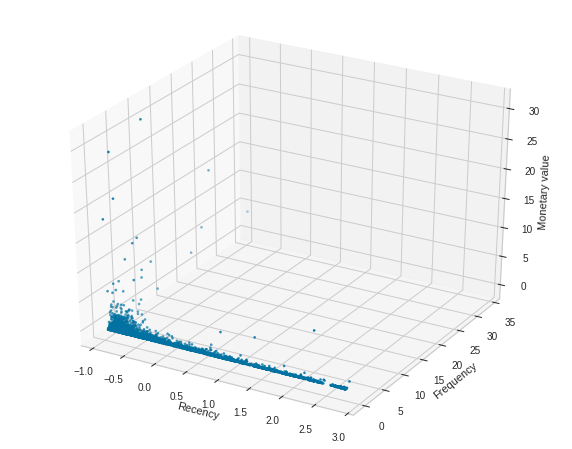

In [35]:
# Importing Library for 3D plot
from mpl_toolkits.mplot3d import Axes3D

# set fig size
fig=plt.figure(figsize=(10,8))

# syntax for 3-D plotting
ax=fig.add_subplot(111,projection='3d')

# syntax for plotting
xs = rfm_df_scaled.Recency
ys = rfm_df_scaled.Frequency
zs = rfm_df_scaled.Monetary
ax.scatter(xs,ys,zs,s=5)

# set x, y & z label
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary value')

# show the plot
plt.show()

## **STEP 6 - Model Training**

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f553a930820>,
                     estimator=KMeans(n_clusters=3))

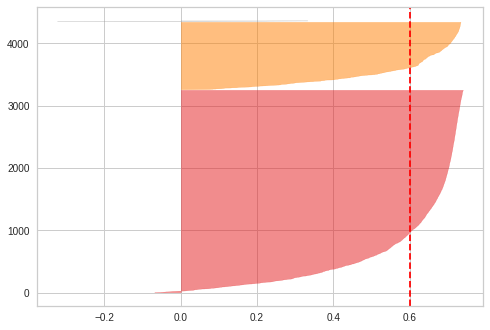

In [36]:
model = SilhouetteVisualizer(KMeans(3))
model.fit(rfm_df_scaled)

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f55399aca30>,
                     estimator=KMeans(n_clusters=4))

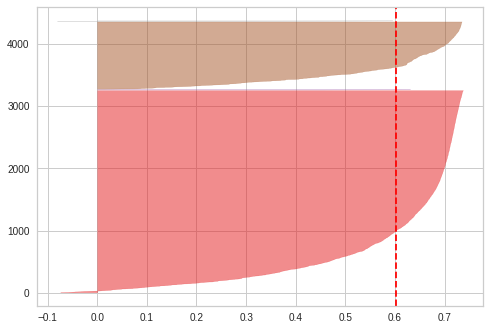

In [37]:
model = SilhouetteVisualizer(KMeans(4))
model.fit(rfm_df_scaled)

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f55390e1160>,
                     estimator=KMeans(n_clusters=5))

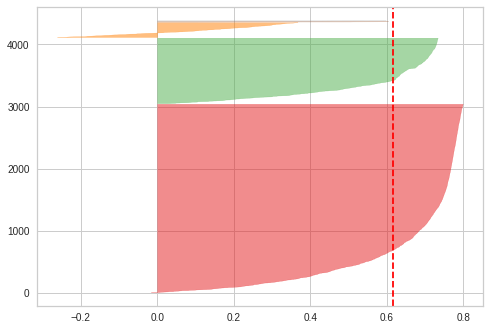

In [38]:
model = SilhouetteVisualizer(KMeans(5))
model.fit(rfm_df_scaled)

In [39]:
ssd = []

for i in range(2,13):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow Method')

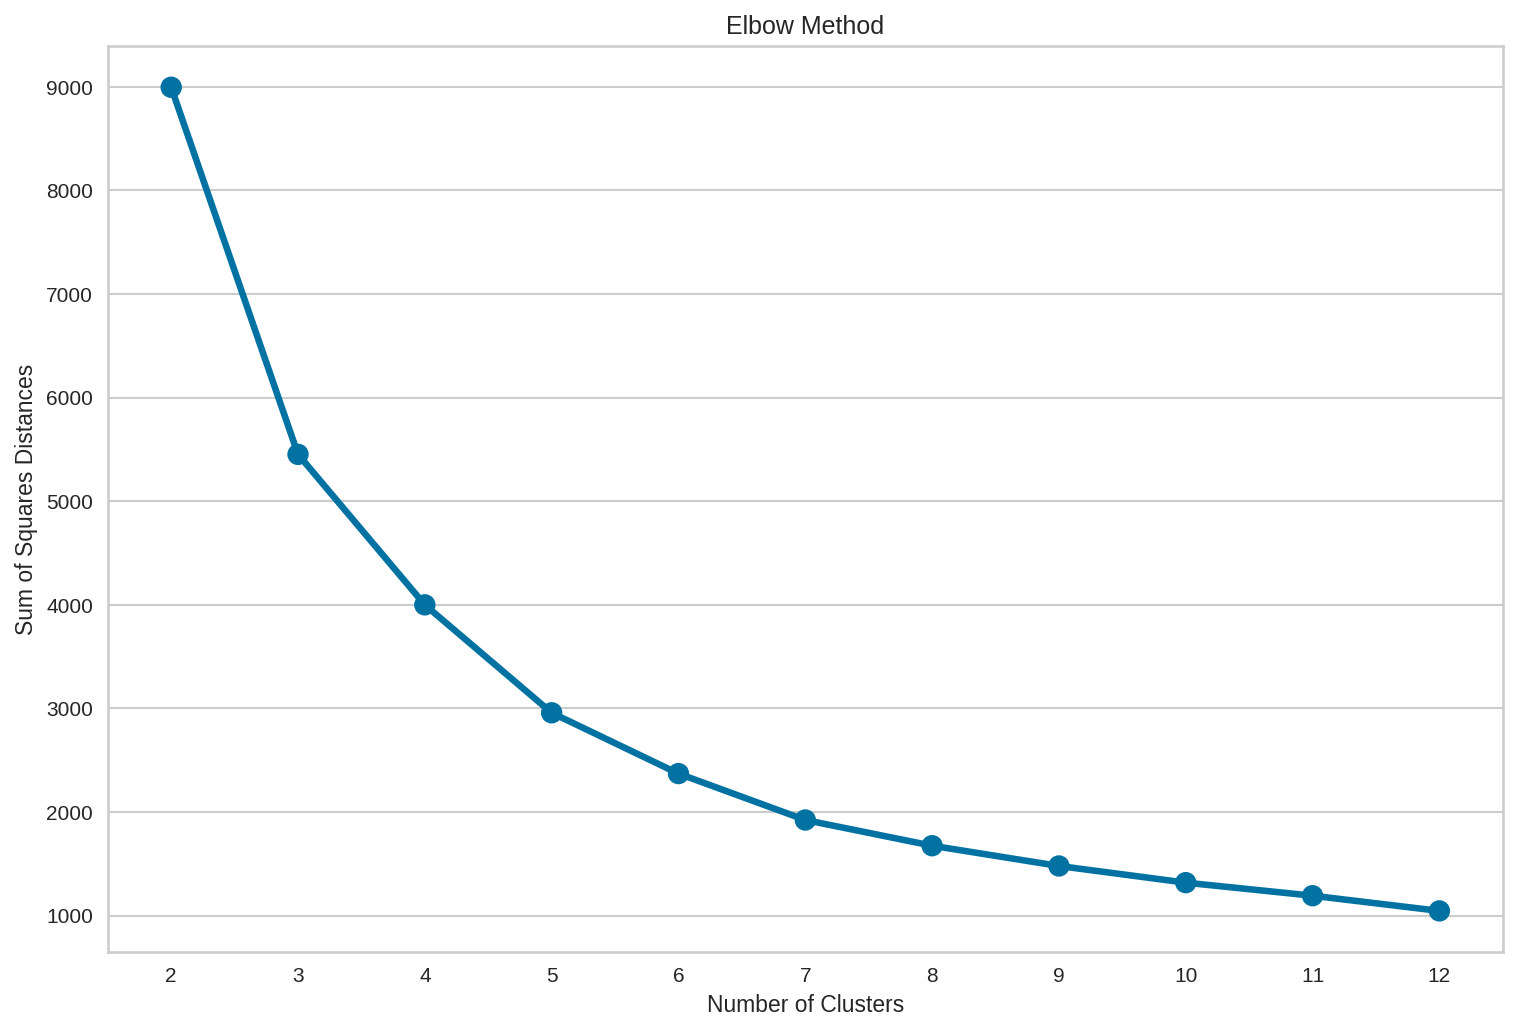

In [40]:
# Elbow Curve
plt.figure(figsize=(12,8),dpi=150)
sns.pointplot(np.arange(2,13),ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Distances')
plt.title('Elbow Method')

In [41]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9311835523719525
For n_clusters=3, the silhouette score is 0.6019775931686978
For n_clusters=4, the silhouette score is 0.5999601196862524
For n_clusters=5, the silhouette score is 0.617537882413287
For n_clusters=6, the silhouette score is 0.5900040344081858
For n_clusters=7, the silhouette score is 0.5242357683148043
For n_clusters=8, the silhouette score is 0.5113864791539183


In [42]:
# assign the label
customer_history_df['cluster_id'] = kmeans.labels_
customer_history_df.head().style.background_gradient(cmap='YlGn', axis=None).text_gradient(cmap='YlGn_r', axis=None).set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Recency,Monetary,Frequency,cluster_id
0,12346.000000,326.000000,77183.600000,1,2
1,12347.000000,2.000000,4310.000000,182,0
2,12348.000000,75.000000,1797.240000,31,3
3,12349.000000,19.000000,1757.550000,73,3
4,12350.000000,310.000000,334.400000,17,1


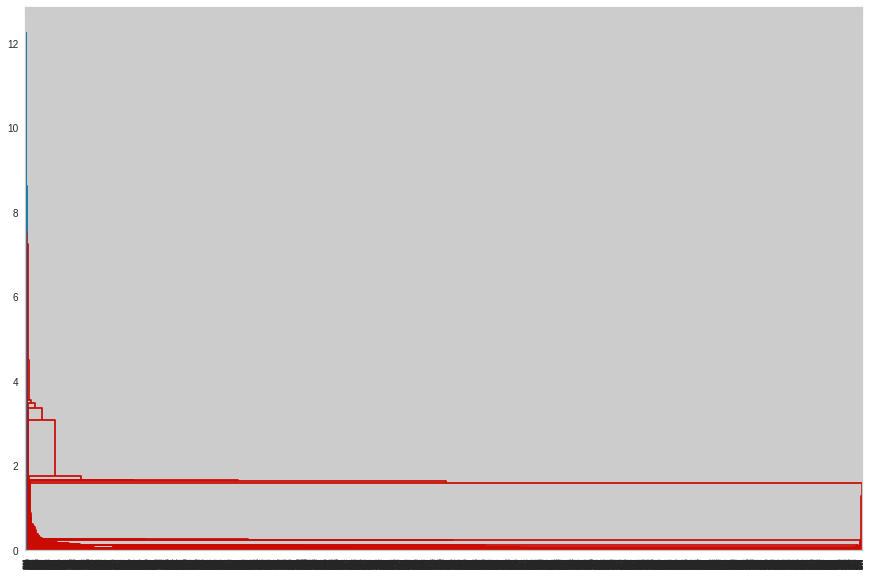

In [43]:
# single linkage
plt.figure(figsize=(15,10))
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

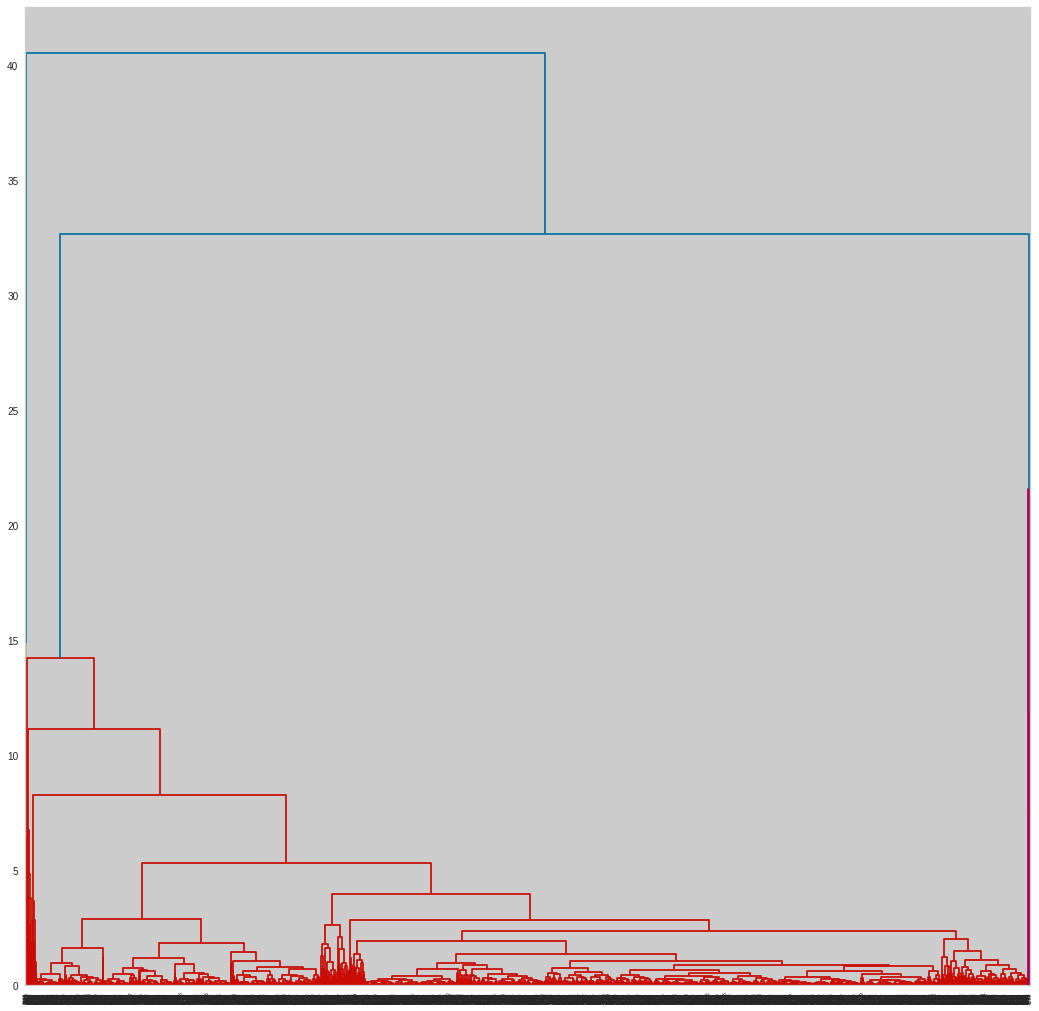

In [44]:
# complete linkage
plt.figure(figsize=(18,18))
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [45]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
# assign cluster labels
customer_history_df['cluster_labels'] = cluster_labels
customer_history_df.head().style.background_gradient().set_properties(**{'border': '1.3px solid red',
                          'color': 'black'})

,CustomerID,Recency,Monetary,Frequency,cluster_id,cluster_labels
0,12346.000000,326.000000,77183.600000,1,2,0
1,12347.000000,2.000000,4310.000000,182,0,0
2,12348.000000,75.000000,1797.240000,31,3,0
3,12349.000000,19.000000,1757.550000,73,3,0
4,12350.000000,310.000000,334.400000,17,1,0


In [47]:
### visualize the result
import plotly.express as px
fig = px.scatter_3d(customer_history_df, x='Recency', y='Frequency', z='Monetary',
              color='cluster_labels')
fig.show()

## **CONCLUSION EDA:**

*   Chart 1 shows correlation heatmap of the dataset, total price and quantity are positively correlated whereas invoice_year and invoice_month are negatively correlated.
*   Chart 2 shows positive correlation between total price and quantity in the form of scattered plot. 

*   Chart 3 shows there are more number of purchases in the year 2011
*   Chart 4 represents that in the maonth of Jan, August, September and December there is surge in total price.

*   In the univariate analysis we saw that quantity,unit price and total price are positively skewed
*   invoice weekday vs quantity shows that most number of purchases are made on friday(black friday sale) and least on sunday 

*   Most purchases are of paper craft, little birdie category followed by picnic baskets.











## **CONCLUSION ML:**

Finally, we looked at how we may divide up our consumer base based on the demands of our company. RFM can be applied to all of your clients or just a portion of them. For instance, you might first create client segments based on a region or other demographics, and then create groups based on historical, transaction-based behaviour. RFM analysis may assist in providing answers to many questions about their customers, which can assist businesses in developing marketing plans for their clients, keeping hold of sliding clients, and making recommendations to clients based on their interests. To divide up our consumer base into multiple clusters with a high degree of similarity, we employed the K-means technique. K-means did a good job, in my opinion.